# NNs in Sklearn

## Classification
Check out the documentation for the MLPClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

75th percentile threshold for MedHouseVal: 2.647
Class balance (0/1): {0: 15480, 1: 5160}

TRAIN RESULTS

Classification Report
              precision  recall  f1-score    support
0                 0.920   0.954     0.937  12384.000
1                 0.845   0.750     0.795   4128.000
accuracy          0.903   0.903     0.903      0.903
macro avg         0.882   0.852     0.866  16512.000
weighted avg      0.901   0.903     0.901  16512.000

Confusion Matrix
          Pred 0  Pred 1
Actual 0   11816     568
Actual 1    1031    3097

VAL RESULTS

Classification Report
              precision  recall  f1-score   support
0                 0.916   0.952     0.934  1548.000
1                 0.837   0.736     0.784   516.000
accuracy          0.898   0.898     0.898     0.898
macro avg         0.876   0.844     0.859  2064.000
weighted avg      0.896   0.898     0.896  2064.000

Confusion Matrix
          Pred 0  Pred 1
Actual 0    1474      74
Actual 1     136     380

TEST RESULTS

Class

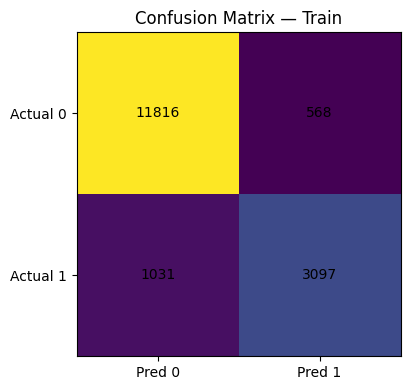

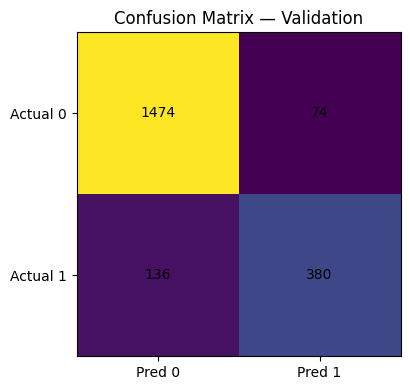

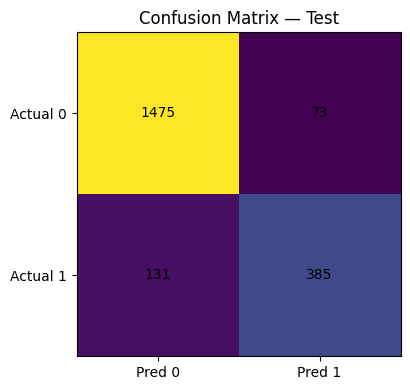

In [1]:
# California Housing → Binary Classification with MLPClassifier (defaults)
# Label = 1 if MedHouseVal > 75th percentile; else 0
# Splits: 80/10/10 (stratified). Standardize features (train-only stats).
# Reports: classification report + confusion matrix for train/val/test.

import warnings
warnings.filterwarnings("ignore")  # keep output tidy; MLP may warn about convergence

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load data
data = fetch_california_housing(as_frame=True)
X = data.frame.drop(columns=["MedHouseVal"])
y_cont = data.frame["MedHouseVal"]

# 2) Recode target to 0/1 via 75th percentile threshold
threshold = y_cont.quantile(0.75)
y = (y_cont > threshold).astype(int)

print(f"75th percentile threshold for MedHouseVal: {threshold:.3f}")
print(f"Class balance (0/1): {(y.value_counts().sort_index().to_dict())}")

# 3) 80/10/10 split — stratified to preserve class ratio
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# 4) Scale features (fit on train only, apply to val/test)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# 5) Default MLPClassifier
clf = MLPClassifier(random_state=42)  # defaults: hidden_layer_sizes=(100,), max_iter=200, etc.
clf.fit(X_train_s, y_train)

# 6) Predictions
preds = {
    "train": clf.predict(X_train_s),
    "val":   clf.predict(X_val_s),
    "test":  clf.predict(X_test_s),
}
truth = {
    "train": y_train.values,
    "val":   y_val.values,
    "test":  y_test.values,
}

# 7) Pretty printers
def pretty_classification_report(y_true, y_pred):
    rpt = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    df = pd.DataFrame(rpt).transpose()
    # Clean up column names and order
    cols = ["precision", "recall", "f1-score", "support"]
    df = df[cols]
    return df

def pretty_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    df = pd.DataFrame(cm, index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"])
    return df

# 8) Show results for each split
for split in ["train", "val", "test"]:
    y_true = truth[split]
    y_pred = preds[split]
    print("\n" + "="*70)
    print(f"{split.upper()} RESULTS")
    print("="*70)
    print("\nClassification Report")
    print(pretty_classification_report(y_true, y_pred).round(3).to_string())
    print("\nConfusion Matrix")
    print(pretty_confusion_matrix(y_true, y_pred).to_string())

# 9) Optional: simple confusion-matrix heatmaps (one chart per split)
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    plt.figure(figsize=(4.5,4))
    plt.imshow(cm)
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.xticks([0,1], ["Pred 0","Pred 1"])
    plt.yticks([0,1], ["Actual 0","Actual 1"])
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Uncomment to visualize:
plot_cm(truth["train"], preds["train"], "Confusion Matrix — Train")
plot_cm(truth["val"],   preds["val"],   "Confusion Matrix — Validation")
plot_cm(truth["test"],  preds["test"],  "Confusion Matrix — Test")
